import numpy and pyJHTDB stuff

In [1]:
import numpy as np
import pyJHTDB
from pyJHTDB.dbinfo import mhd1024, isotropic1024coarse
from pyJHTDB import libJHTDB
import time as tt
#import mkl_fft

now import matplotlib and require plots to be shown inline

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

Generate points adequate for the isotropic Navier Stokes data set.

In [3]:
info    = isotropic1024coarse
nlines  = 4
ntimes  = 16
spacing = info['dx']

x = np.zeros((nlines, info['nx'], 3), dtype = np.float32)
x0 = np.linspace(0, info['nx']*spacing, num = info['nx'], endpoint=False)

e = np.random.randint(3, size=nlines) #line direction. e=0, x-direction; e=1 y-direction; e=2 z-direction

time = np.random.choice(info['time'], size = ntimes)

Get the velocity field at the above points, i.e. on lines.
Since the flow is quasistationary, whether we're averaging over space or time shouldn't really matter, therefore we're reshaping the array on the last line to make things easier.

In [4]:
lJHTDB = libJHTDB()
lJHTDB.initialize()

#Add token
auth_token  = "edu.jhu.pha.turbulence.testing-201311"  #Replace with your own token here
lJHTDB.add_token(auth_token)

u = []
for t in range(time.shape[0]):
    print (t)
    d = 0
    for i in e:
        x[d, :, e] = x0;
        if i == 0:
            x[d, :, [1, 2]] = np.random.random(size=(2,1))*info['nx']*spacing
        elif i == 1:
            x[d, :, [0, 2]] = np.random.random(size=(2,1))*info['nx']*spacing
        elif i == 2:
            x[d, :, [0, 1]] = np.random.random(size=(2,1))*info['nx']*spacing
        d = d + 1
    
    u.append(lJHTDB.getData(time[t], x, data_set = info['name'],
        getFunction = 'getVelocity'))
lJHTDB.finalize()
u = np.array(u).reshape(nlines*ntimes, x.shape[1], -1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


Perform the inverse Fourier transform, and construct an array for the corresponding wavenumbers.
While not technically essential, this gives a starting point for the proper treatment of anisotropic grids (such as the channel flow grid).

In [5]:
uk = np.fft.rfft(u, axis = 1) / u.shape[1]
k0 = 2*np.pi / (spacing * x.shape[1])
k = k0*np.linspace(1, uk.shape[1]+1, num = uk.shape[1])
ek = .5*np.average(np.sum(np.abs(uk)**2, axis = 2), axis = 0)

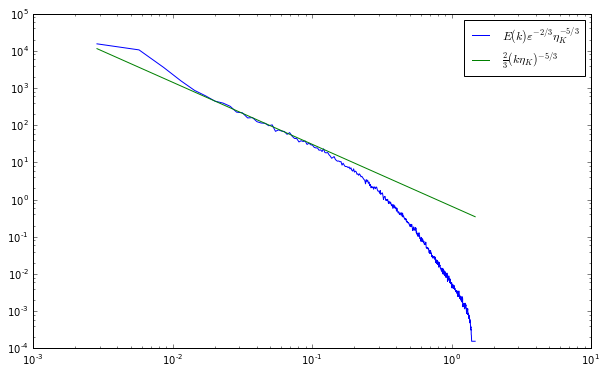

In [6]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
etaK = ((info['nu']**3)/info['diss'])**.25
ax.plot(k*etaK,
        ek / ((info['diss']**(2./3)) * (etaK**(5./3))),
        label = '$E(k)\\varepsilon^{-2/3}\\eta_K^{-5/3}$')
ax.plot(k*etaK,
        2*(k*etaK)**(-5./3) / 3,
        label = '$\\frac{2}{3}(k \\eta_K)^{-5/3}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc = 'best')